CNN FACE/ANIMAL RECOGNITION & SORTER WITH AUTO FACE CROP + FALLBACK FOR NON-HUMAN

In [230]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import shutil




PARAMETERS

In [231]:
# Konfigurasi awal
tf.config.run_functions_eagerly(True)  # Atasi error eager
IMG_SIZE = (160, 160)
BATCH_SIZE = 16
DATA_DIR = 'faces'  # Struktur folder: faces/ivan/, faces/ivy/
MODEL_NAME = 'face_cnn_model.h5'


Dat Prep

In [232]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

class_labels = list(train_data.class_indices.keys())


Found 79 images belonging to 2 classes.
Found 19 images belonging to 2 classes.


CNN MODEL

In [233]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(train_data.class_indices), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [234]:
import shutil

# Hapus folder hasil prediksi sebelumnya
if os.path.exists('sorted'):
    shutil.rmtree('sorted')
    print("📁 Folder 'sorted' sebelumnya dihapus.")


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7880 - loss: 0.5455 - val_accuracy: 0.8947 - val_loss: 0.1312
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9034 - loss: 0.2607 - val_accuracy: 1.0000 - val_loss: 0.2763
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 1.0000 - loss: 0.1110 - val_accuracy: 1.0000 - val_loss: 0.0355
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 1.0000 - val_loss: 0.0095
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 1.0000 - loss: 2.0319e-04 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 1.0000 - loss: 3.0894e-05 - val_accuracy: 1.0000 - val_loss: 0.0133
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 1.0000 - loss: 6.3452e-06 - val_accuracy: 1.0000 - val_loss: 0.0

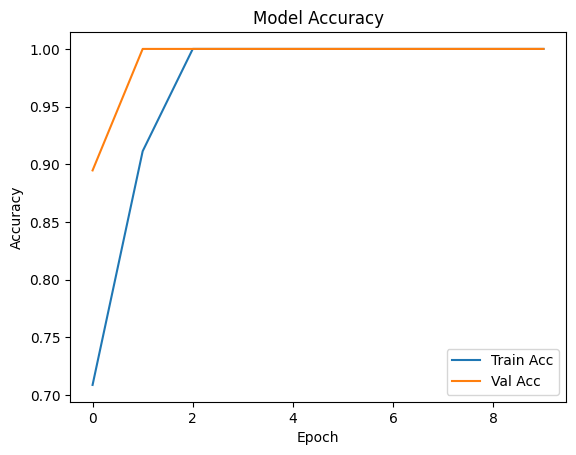

In [235]:
history = model.fit(train_data, validation_data=val_data, epochs=10)
model.save(MODEL_NAME)

# (opsional) Visualisasi
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


PREDICT FUNCTION

In [ ]:
def predict_and_sort(image_path, model, class_labels, output_dir='sorted'):
    img_raw = cv2.imread(image_path)
    if img_raw is None:
        print(f"❌ Gagal membaca gambar: {image_path}")
        return

    print("📸 Menggunakan full image (tanpa crop wajah).")
    face_img = cv2.resize(img_raw, IMG_SIZE)

    img_array = face_img / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    confidence = np.max(pred)
    predicted_class = np.argmax(pred)
    class_name = class_labels[predicted_class] if confidence > 0.8 else 'unknown'

    save_dir = os.path.join(output_dir, class_name)
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.basename(image_path)
    shutil.copy(image_path, os.path.join(save_dir, filename))
    print(f"Predicted: {class_name} ({confidence:.2f}) → saved to {save_dir}")


LOAD MODEL & CLASS LABELS

In [ ]:
model = tf.keras.models.load_model(MODEL_NAME)
class_labels = list(train_data.class_indices.keys())

# Ganti dengan path gambar input
predict_and_sort("miaw.jpg", model, class_labels)


✅ Wajah berhasil dicrop.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted: ivy (1.00) → saved to sorted\ivy


: 